<a href="https://colab.research.google.com/github/andysingal/machining-learning/blob/main/Training_Models_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations ab, a2b, and ab2.**

Saving figure high_degree_polynomials_plot


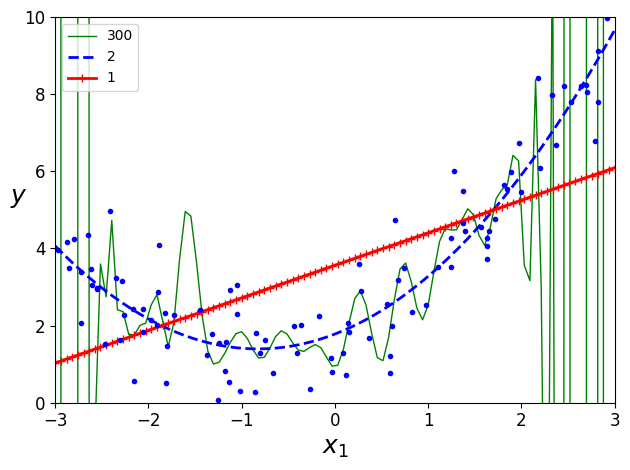

In [2]:
m = 100
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

#Learning Curves

Saving figure underfitting_learning_curves_plot


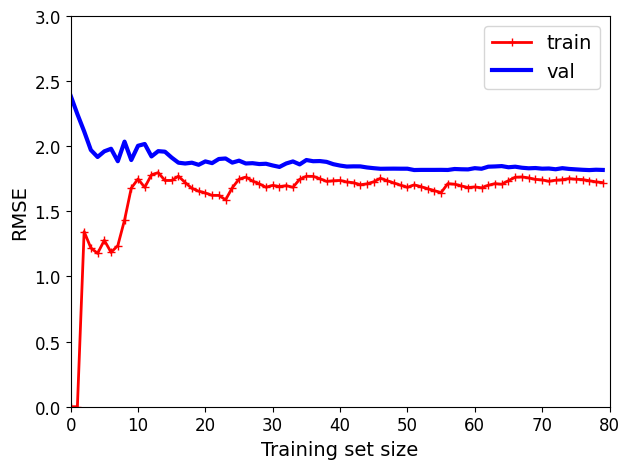

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data

Saving figure learning_curves_plot


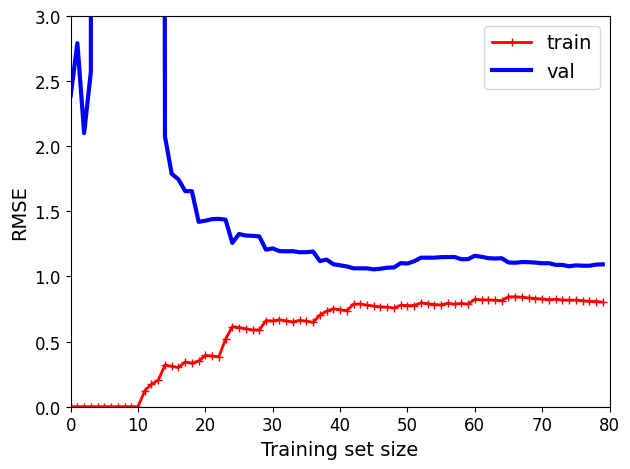

In [4]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

These learning curves look a bit like the previous ones, but there are two very important differences:

- The error on the training data is much lower than with the Linear Regression model.

- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

**One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.**



**THE BIAS/VARIANCE TRADE-OFF**

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

**Bias**
- This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.8

**Variance**
- This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.

**Irreducible error**
- This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.

**Regularized Linear Models**

A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

In [5]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

**It is important to scale the data (e.g., using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.**

Saving figure ridge_regression_plot


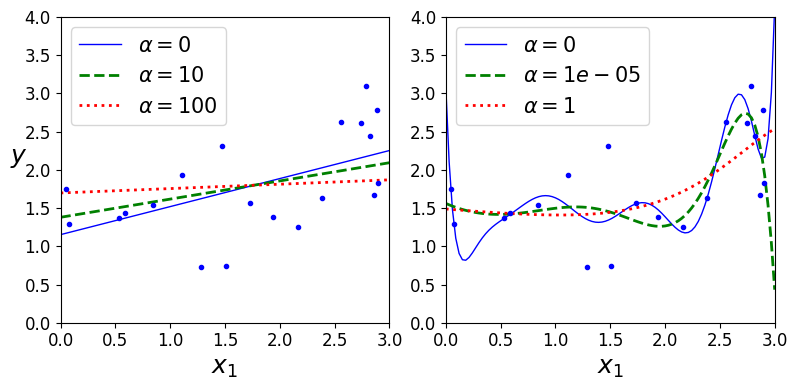

In [6]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [15]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.81978491])

# Lasso Regression


- Least Absolute Shrinkage and Selection Operator Regression (usually simply called Lasso Regression) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the ℓ1 norm of the weight vector instead of half the square of the ℓ2 norm

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e+00, tolerance: 8.185e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


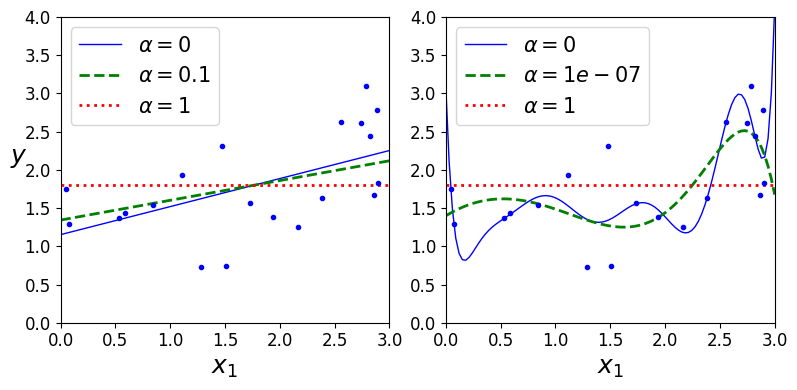

In [7]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

**An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features**

**Lasso Regression automatically performs feature selection and outputs a sparse model **

In [8]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.73090508])

Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r.

Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features’ weights down to zero, as we have discussed. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [12]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])


array([4.78114505])

#Early Stopping

In [17]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [21]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=1e-3, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_

#Logistic Regression